<a href="https://colab.research.google.com/github/Flymshady/traffic_classifier/blob/main/classifi_traffic_imported_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install -q pytorch-lightning
! pip install -q pytorch-lightning-bolts

In [2]:
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
fid = drive.ListFile({'q':"title='entire_model.pt'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('entire_model.pt')

In [6]:
class_names = ['error', 'no_traffic', 'traffic']

In [13]:
def imgshow(inp, title=None):      #metoda pro zobrazeni jednoho batche
  inp = inp.numpy().transpose((1,2,0)) #vraceni zpatky z transforms
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  inp = std * inp + mean #transfromace
  inp = np.clip(inp, 0, 1)

  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

In [7]:
class TrafficModel(pl.LightningModule):

    def __init__(self, num_target_classes):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True) #vyuziti preneseneho uceni z modelu resnet50
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_target_classes)
        self.acc = pl.metrics.Accuracy()

    def forward(self, x):
      return self.model(x)

    def training_step(self, batch, batch_idx):  
       
       x, y = batch #rozdeleni batche na jeho dva prvky - vstup a cile(labely)

       y_hat = self(x)  #output modelu

       loss = F.cross_entropy(y_hat, y) #vypocet chyby - ztratova funkce cross_entropy
       self.log('train_loss', loss)   #ulozeni ztraty do logu
       self.log('train_acc_step', self.acc(y_hat, y), on_step=True, on_epoch=False)  #y_hat - predikovana, y - co melo byt predikovanp -> vypocet kolik % z toho bylo spravne
       return loss

    def training_epoch_end(self, outs):
      acc = self.acc.compute()
      self.log("train_acc_epoch", acc)

    def validation_step(self, batch, batch_idx):

        x, y = batch
        y_hat = self(x)  #output modelu
        loss = F.cross_entropy(y_hat, y) #vypocet chyby - ztratova funkce cross_entropy
        self.log('val_loss', loss)
  
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-3, momentum=0.9)
        return optimizer

model = TrafficModel(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [8]:
model = torch.load('entire_model.pt')
model.eval()

TrafficModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [9]:
import os

# define the name of the directory to be created
os.chdir('/content/')
path = "/content/actuall"

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

os.chdir('/content')

Successfully created the directory /content/actuall 


In [10]:
import requests
def download_image(place_t):
  os.chdir('/content/actuall')
  with open(place_t+'.jpg', 'wb') as handle:
        response = requests.get('http://kamery.lwq.cz/jpg/'+place_t+'.jpg', stream=True)
        if not response.ok:
            print(response)
        for block in response.iter_content(1024):
            if not block:
                break
            handle.write(block)

In [15]:
from PIL import Image
import datetime

device = torch.device("cuda")

def classify_traffic_place(model, place):
  if place == 0:
    place_t = 'barton-vysokov'
  elif place == 1:
    place_t = 'barton-centrum'
  elif place == 2:
    place_t = 'barton'
  elif place == 3:
    place_t = 'slavia'
  elif place == 4:
    place_t = 'italie'
  elif place == 5:
    place_t = 'polska'
  else: return
  os.chdir('/content/actuall')
  if os.path.exists('/content/actuall/'+place_t+'.jpg'):
      os.remove('/content/actuall/'+place_t+'.jpg')
  else:
    print("The file does not exist")
  
  download_image(place_t)

  

  img = Image.open('/content/actuall/'+place_t+'.jpg')

  transform_image = transforms.Compose([
                                 transforms.Resize((224,224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  img_t = transform_image(img)
  batch_t = torch.unsqueeze(img_t, 0)

  device = torch.device("cuda")
  model.eval()
  fig = plt.figure()
  batch_t = batch_t.to(device)
  out = model(batch_t)
  _, classifs = torch.max(out, 1)
  ax = plt.subplot()
  ax.axis("off")
  ax.set_title("Classified: {}".format(class_names[classifs]))
  imgshow(batch_t.cpu().data[0])
  ct = datetime.datetime.now() 
  ct= str(ct)
  print(place_t + ': '+ class_names[classifs] + ', time: '+ ct)
  return class_names[classifs]
  model.to(device)

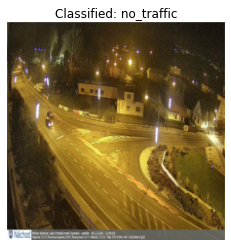

barton-vysokov: no_traffic, time: 2020-12-06 20:12:53.222313


'no_traffic'

In [16]:
classify_traffic_place(model, 0)
